In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
#%matplotlib qt

import os
os.chdir('/content/drive/MyDrive/New_MOACOR/')
cwd= os.getcwd()

%run moacor_functions

In [ ]:
pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=a8c0cd4df466d0f37cc43c06a1497f0726a265ec8818cad55b7edcd2581469eb
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
import numpy as np
import pandas as pd
import numpy.matlib
import itertools
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from mpl_toolkits.mplot3d import axes3d

import plotly.graph_objects as go

from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV

from IPython.display import clear_output
from mpl_toolkits.mplot3d import axes3d
from pandas.plotting import parallel_coordinates

import time

In [ ]:
# Plot the points in 3 dimensions.
def plot_3d(points, title):
    x, y, z = zip(*points)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_zlabel("f3")
    ax.set_title(title)
    ax.view_init(45, 45, 0)
    plt.show()

# Plot the points in 3 dimensions.
def plot_2d(points, title):
    x, y = zip(*points)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_title(title)
    plt.show()

# Plot the parallel coordinates.
def parallel_plot(points,title):
    final_evals_df = pd.DataFrame(points)
    final_evals_df['Color'] = 1
    plt.figure(figsize=(4, 2))
    parallel_coordinates(final_evals_df,'Color', colormap='viridis', linewidth=1)
    plt.title(title)
    plt.xlabel('Objective')
    plt.ylabel('Evaluation')
    plt.show()

In [ ]:
def SLD(N, m, inverted):
    """Generates approximately N uniformly distributed points using the Simplex-Lattice Design with two layers"""
    H1 = 1
    while (math.comb(H1+m, m-1) <= N):
        H1 += 1
    W = nchoosek(list(range(1, H1+m)), m-1)-np.matlib.repmat(np.arange(0, m-1), math.comb(H1+m-1, m-1), 1)-1
    W = (np.hstack((W, np.zeros([len(W), 1])+H1))-np.hstack((np.zeros([len(W), 1]), W)))/H1
    if (H1 < m):
        H2 = 0
        while (math.comb(H1+m-1, m-1)+math.comb(H2+m, m-1) <= N):
            H2 += 1
        if (H2 > 0):
            print("m = {0} H1 = {1} H2 = {2}\n".format(m, H1, H2))
            W2 = nchoosek(list(range(1, H2+m)), m-1)-np.matlib.repmat(np.arange(0, m-1), math.comb(H2+m-1, m-1), 1)-1
            W2 = (np.hstack((W2, np.zeros([len(W2), 1])+H2))-np.hstack((np.zeros([len(W2), 1]), W2)))/H2
            W2 = W2/2+1/(2*m)
            W = np.vstack((W, W2))
        #print("m = {0} H1 = {1} H2 = {2}\n".format(m, H1, H2))
    else:
        #print("m = {0} H1 = {1}\n".format(m, H1))
        variable_to_not_cause_error = 0
    N = len(W)
    if not inverted:
        return W
        #np.savetxt('output/SLD'+'_{0:0=2d}D'.format(m)+'_'+str(N)+'.pof', W, '%.6f', header=str(N)+' '+str(m))
    else:
        return (-W+1)
        #np.savetxt('output/INV_SLD'+'_{0:0=2d}D'.format(m)+'_'+str(N)+'.pof', -W + 1, '%.6f', header=str(N)+' '+str(m))
    return

def nchoosek(v, k):
    """Returns a matrix with all combinations of v taken k at a time"""
    return np.array(list(itertools.combinations(v, k)))

In [ ]:
def u_asf(v,ideal,w):
    m = len(v)
    a = []
    for i in range(m):
        b = (1/w[i])*np.absolute(v[i]-ideal[i])
        a.append(b)
    return max(a)

In [ ]:
def infinite_array(n):
    return np.full(n, np.inf)

In [ ]:
def ideal_vector(matrix):
    num_cols = len(matrix[0])
    min_vals = [float('inf')] * num_cols
    for col_idx in range(num_cols):
        for row_idx in range(len(matrix)):
            if matrix[row_idx][col_idx] < min_vals[col_idx]:
                min_vals[col_idx] = matrix[row_idx][col_idx]
    return min_vals

In [ ]:
def nadir_vector(matrix):
    num_cols = len(matrix[0])
    max_vals = [-float('inf')] * num_cols
    for col_idx in range(num_cols):
        for row_idx in range(len(matrix)):
            if matrix[row_idx][col_idx] > max_vals[col_idx]:
                max_vals[col_idx] = matrix[row_idx][col_idx]
    return max_vals

In [ ]:
def l2_norm_func(a,n_vars,n_funcs):
    l2_norm = infinite_array(a.shape[0])
    counter = 0
    for b in a:
        sum_sqrt = 0
        for i in range(n_funcs):
            sum_sqrt = sum_sqrt + b[n_vars+i]**2
        l2_norm[counter] = sum_sqrt**0.5
        counter = counter + 1
    return(l2_norm)

In [ ]:
def normalize(archive,ideal,nadir,n_vars,n_funcs):
    for i in range(n_funcs):
            new_column = infinite_array(archive.shape[0])
            new_column = new_column.reshape(-1, 1)
            archive = np.concatenate((archive,new_column), axis=1)

    count = 0
    for p in archive:
        for i in range(n_funcs):
            a = (p[i+n_vars]-ideal[i])/(nadir[i]-ideal[i])
            archive[count,n_vars+n_funcs+i] = a
        count = count + 1
    return archive

In [ ]:
def ranking2(archive,weight_vectors,n_vars,n_funcs,ideal):
    zeros_array = np.zeros(n_funcs)
    p_rank = infinite_array(archive.shape[0])
    p_rank = p_rank.reshape(-1, 1)
    archive_1 = np.concatenate((archive,p_rank,p_rank,p_rank,p_rank), axis=1) #p_rank +0,p_alpha +1,l2_norm +2, p_utility +3

    for w in weight_vectors:

        p_alpha = []

        for p in archive_1:
            p_alpha.append(u_asf(p[n_vars+n_funcs:n_vars+2*n_funcs],zeros_array,w))
        archive_1[:,n_vars+2*n_funcs+1] = p_alpha

        l2_norm = l2_norm_func(archive_1,n_vars,n_funcs)
        archive_1[:,n_vars+2*n_funcs+2] = l2_norm

        archive_1 = archive_1[np.argsort(archive_1[:,n_vars+2*n_funcs+2])] # Sort with l2 norm
        archive_1 = archive_1[np.argsort(archive_1[:,n_vars+2*n_funcs+1])] # Sort with alpha values

        rank = 1

        for i in range(archive_1.shape[0]):
            if rank < archive_1[i][n_vars+2*n_funcs]:
                archive_1[i][n_vars+2*n_funcs] = rank
                archive_1[i][n_vars+2*n_funcs+3] = archive_1[i][n_vars+2*n_funcs+1]
            rank = rank + 1

    return archive_1

In [ ]:
def update_reference_points(population,z_min,z_max,n_funcs,n_vars):
    global record
    ideal = ideal_vector(population[:,n_vars:n_vars+n_funcs])
    nadir = nadir_vector(population[:,n_vars:n_vars+n_funcs])
    z_min = np.minimum(ideal,z_min)
    record = np.vstack((record,z_min))
    if record.shape[0] > 5:
        record = np.delete(record,0,0)
    variance_vector = np.var(record, axis=0)
    if np.max(variance_vector) > 0.5:
        z_max = nadir
    else:
        for i in range(n_funcs):
            if np.absolute(z_max[i]-z_min[i]) < 0.001:
                z_max[i] = np.max(z_max)
                # 11 mark z_max[i]
            elif nadir[i] > z_max[i]:
                z_max[i] = 2*nadir[i]-z_max[i]
                # 14 mark z_max[i]
            elif variance_vector[i] == 0:
                a = np.max(nadir)
                z_max[i] = (z_max[i] + a)/2
                # mark z_max
    return z_min,z_max

In [ ]:
def evaluate_function(problem, sols_to_eval, n_funcs, n_vars, inverted_flag):
    if ("DTLZ" in problem):
        ref_dirs = get_reference_directions("das-dennis", n_funcs, n_partitions=12)
        problem_pymoo = get_problem(problem, n_var=n_vars, n_obj=n_funcs)
        evaluations = problem_pymoo.evaluate(sols_to_eval)
    elif ("WFG" in problem):
        k_var = ( n_funcs - 1 ) * 2
        if n_funcs < 3:
            k_var = 4
        ref_dirs = get_reference_directions("das-dennis", n_funcs, n_partitions=12)
        problem_pymoo = get_problem(problem, n_var=n_vars, n_obj=n_funcs, k=k_var)
        evaluations = problem_pymoo.evaluate(sols_to_eval)
    else:
        evaluations = evaluate_solutions(sols_to_eval, n_funcs, problem, n_vars)
    if (inverted_flag):
        evaluations = -1 * evaluations
    return evaluations

All good to start, validation complete
Total experiments:  32
210
Experiment Completed:  31
Elapsed time:  948.4849331378937


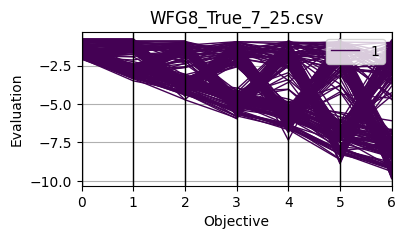

210
Experiment Completed:  32
Elapsed time:  940.6235680580139


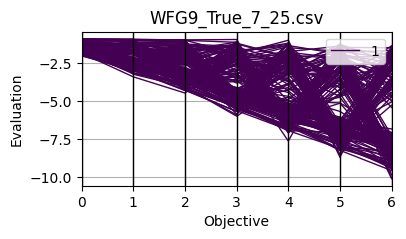

IndexError: list index out of range

In [ ]:
seed_arr = [1]
for seed in seed_arr:

    # This is for 2 objectives.
    n_funcs = 2
    total_evals = 40000
    n_final = 120

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "IMOP1","IMOP2","IMOP3",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [6,11,11,11,11,11,21,
                  6,11,11,11,11,11,21,
                  10,10,10,
                  24,24,24,24,24,24,24,24,24,
                  24,24,24,24,24,24,24,24,24]

    '''
    # This is for 3 objectives.
    n_funcs = 3
    total_evals = 50000
    n_final = 120

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "IMOP4","IMOP5","IMOP6","IMOP7","IMOP8",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "VIE1","VIE2","VIE3"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True,
                        False,False,False]

    n_vars_arr = [7,12,12,12,12,12,22,
                  7,12,12,12,12,12,22,
                  10,10,10,10,10,
                  26,26,26,26,26,26,26,26,26,
                  26,26,26,26,26,26,26,26,26,
                  2,2,2]
    '''

    '''
    # This is for 5 objectives.
    n_funcs = 5
    total_evals = 70000
    n_final = 126

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [9,14,14,14,14,14,24,
                  9,14,14,14,14,14,24,
                  30,30,30,30,30,30,30,30,30,
                  30,30,30,30,30,30,30,30,30]
    '''

    '''
    # This is for 7 objectives.
    n_funcs = 7
    total_evals = 90000
    n_final = 210

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [11,16,16,16,16,16,26,
                  11,16,16,16,16,16,26,
                  34,34,34,34,34,34,34,34,34,
                  34,34,34,34,34,34,34,34,34]
    '''


    if len(problem_arr) == len(n_vars_arr) and len(problem_arr) == len(inverted_flag_arr):
        print('All good to start, validation complete')

    total_different_experiments = len(problem_arr)
    print('Total experiments: ', total_different_experiments)

    for current in range(total_different_experiments):

        current = current + 30

        # Problem Variables.
        problem = problem_arr[current]
        inverted_flag = inverted_flag_arr[current]
        n_vars = n_vars_arr[current]

        np.random.seed(seed)
        start_time = time.time()

        k = n_final
        np.random.seed(seed)
        weight_vectors = SLD(k, n_funcs, 0) + 0.0001
        k = weight_vectors.shape[0]
        n_sols = k
        print(n_sols)
        epsilon = 0.5 # Influences the standard deviation, the bigger the more random.
        partitions = 12

        weight_vectors = SLD(k, n_funcs, 0) + 0.0001
        mop_data = mop_data_func(n_vars,problem)
        sols = initial_random_solutions(mop_data,n_sols)
        eval_sols = evaluate_function(problem, sols, n_funcs, n_vars, inverted_flag)
        archive = np.concatenate((sols,eval_sols), axis=1)

        ideal = ideal_vector(archive[:,n_vars:n_vars+n_funcs])
        nadir = nadir_vector(archive[:,n_vars:n_vars+n_funcs])

        archive = normalize(archive,ideal,nadir,n_vars,n_funcs)
        record = nadir
        archive = ranking2(archive,weight_vectors,n_vars,n_funcs,ideal)

        fn_evals = n_sols
        gen = 1

        file_to_save = np.empty([n_vars + n_funcs + 1])

        # Stack the output at the moment to the final archive that will be uploaded.
        output_at_the_moment = archive[:,:n_vars + n_funcs]
        generation_array = np.zeros((output_at_the_moment.shape[0],1))
        for i in range(output_at_the_moment.shape[0]):
            generation_array[i] = fn_evals
        generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
        file_to_save = np.vstack((file_to_save,generation_to_save))


        while fn_evals < total_evals:
            new_sols = np.empty([n_vars])
            for solution in archive:
                new_modified_sol = newSolution(archive,solution[:n_vars],epsilon,mop_data,n_vars)
                new_sols = np.vstack((new_sols,new_modified_sol))
            new_sols = np.delete(new_sols,0,0)
            eval_new_sols = evaluate_function(problem, new_sols, n_funcs, n_vars, inverted_flag)
            new_archive = np.concatenate((new_sols,eval_new_sols), axis=1)

            ideal,nadir = update_reference_points(new_archive,ideal,nadir,n_funcs,n_vars)

            super_archive = np.vstack((archive[:,:n_vars+n_funcs],new_archive))
            super_archive = normalize(super_archive,ideal,nadir,n_vars,n_funcs)
            super_archive = ranking2(super_archive,weight_vectors,n_vars,n_funcs,ideal)

            super_archive = super_archive[np.argsort(super_archive[:,n_vars+2*n_funcs+2])] # Sort with l2 norm
            super_archive = super_archive[np.argsort(super_archive[:,n_vars+2*n_funcs+3])] # Sort with p_utility
            super_archive = super_archive[np.argsort(super_archive[:,n_vars+2*n_funcs+0])] # Sort with p_rank

            archive = super_archive[:k,:]

            fn_evals = fn_evals + n_sols
            gen = gen + 1

            if ((gen)%10) == 0:
                # Stack the output at the moment to the final archive that will be uploaded.
                output_at_the_moment = archive[:,:n_vars + n_funcs]
                generation_array = np.zeros((output_at_the_moment.shape[0],1))
                for i in range(output_at_the_moment.shape[0]):
                    generation_array[i] = fn_evals
                generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
                file_to_save = np.vstack((file_to_save,generation_to_save))

        # Stack the output at the moment to the final archive that will be uploaded.
        output_at_the_moment = archive[:,:n_vars + n_funcs]
        generation_array = np.zeros((output_at_the_moment.shape[0],1))
        for i in range(output_at_the_moment.shape[0]):
            generation_array[i] = fn_evals
        generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
        file_to_save = np.vstack((file_to_save,generation_to_save))

        file_to_save = np.delete(file_to_save,0,0)
        df = pd.DataFrame(file_to_save)
        tile_of_file = problem + "_" + str(inverted_flag) + "_" + str(n_funcs) + "_" + str(seed) + ".csv"
        df.to_csv("/content/drive/MyDrive/iMOACOR/" + tile_of_file)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print('Experiment Completed: ', current + 1)
        print("Elapsed time: ", elapsed_time)

        parallel_plot(output_at_the_moment[:,n_vars:n_vars+n_funcs], tile_of_file)